### Replicating Vision Transfomrrer

https://arxiv.org/pdf/2010.11929

## Setup

In [2]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1457), reused 1401 (delta 1401), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 27.74 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [4]:
# Setup device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

In [5]:
# Download pizza, steak, sushi images from GitHub

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [6]:
# Setup directory paths to train and test images

train_dir = image_path / "train"
test_dir = image_path / "test"

In [7]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Create Dataset and DataLoaders

In [8]:
from going_modular.going_modular import data_setup
from torchvision import transforms

# Create image size

IMG_SIZE = 224 # based on ViT paper

# Create transforms pipeline

manual_transforms = transforms.Compose([
    transforms.Resize([IMG_SIZE, IMG_SIZE]),
    transforms.ToTensor()
])

print(f'Manual transforms: {manual_transforms}')

Manual transforms: Compose(
    Resize(size=[224, 224], interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [9]:
# Create batch size of 32 instead of 4096 like in the ViT paper.

BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir= train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### Visualize single image

In [10]:
# Get batch of images

image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch

image, label = image_batch[0], label_batch[0]

# View image shape

image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

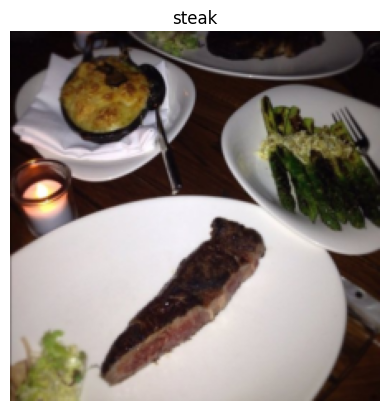

In [11]:
# Plot the image with matplotlib

import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0)) # (color_channels, height width) -> (height, widdth, color_channels) changeing order of axes

plt.title(class_names[label])
plt.axis(False);

## ViT Architecture: Overview

* ViT-B/16 - ViT-Base with the image patch size 16x16
* Layers - the number oftransformer encoder layers/blocks
* Hidden size $D$ - the embedding size throughout the architecture
* MLP - the number of hidden units/neurons in the MLP
* Heads - the number of multi-head self-attention

### Equation 1: Split data into patches and creating the class, position and patch embeddings

* Input shape: ${H×W×C}$
* Output shape: ${N×(P^2⋅C)}$

* $H$ = height
* $W$ = width
* $C$ = color channels
* $P$ = patch size
* $N$ = the number of patches = ${(H×W)÷P^2}$
* $D$ = embedding dimension

In [12]:
# Create example values

height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size ** 2)
number_of_patches

196

In [13]:
# Input shape

embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size ** 2 * color_channels)


print(f'Input shape (single 2d image): {embedding_layer_input_shape}')

# Output shape: 196 patches of 16x16 size, 768 size for each 16x16 patch of 3 channels

print(f'Output shape (single 1d sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)')

Input shape (single 2d image): (224, 224, 3)
Output shape (single 1d sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


##### Turning single image into patches

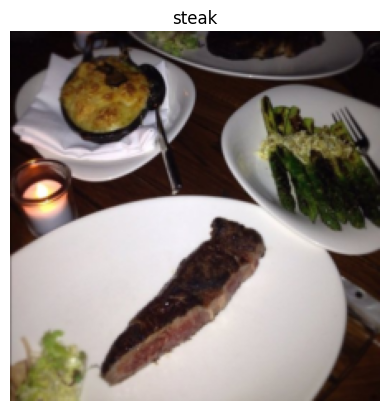

In [14]:
# View single image

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [15]:
image.shape

torch.Size([3, 224, 224])

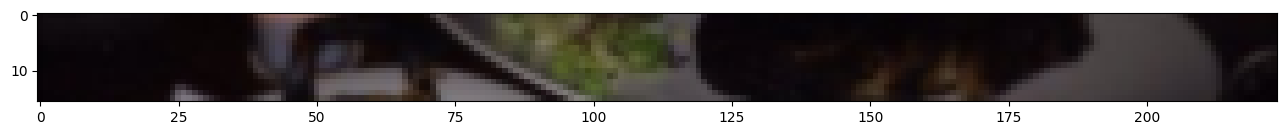

In [16]:
# Get the top row of the image

image_permuted = image.permute(1, 2, 0) # convert image to color channels last (H, W ,C)

# Index to plot the top row of pixels

patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


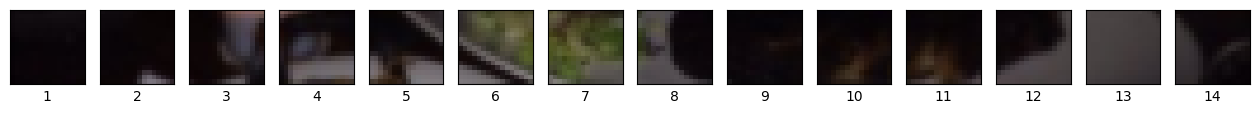

In [17]:
# Setup code to plot top row as patches

img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f'Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels')

# Create a series of subplots
fig, axs = plt.subplots(
    nrows=1,
    ncols=img_size // patch_size, # one column for each patch
    sharex=True,
    sharey=True,
    figsize=(patch_size, patch_size)
)

# Iternatethrough the number of patches in the top row

for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i+1) # set patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0  
Number of patches per column: 14.0  
Total patches: 196.0  
Patch size: 16 pixels x 16 pixels


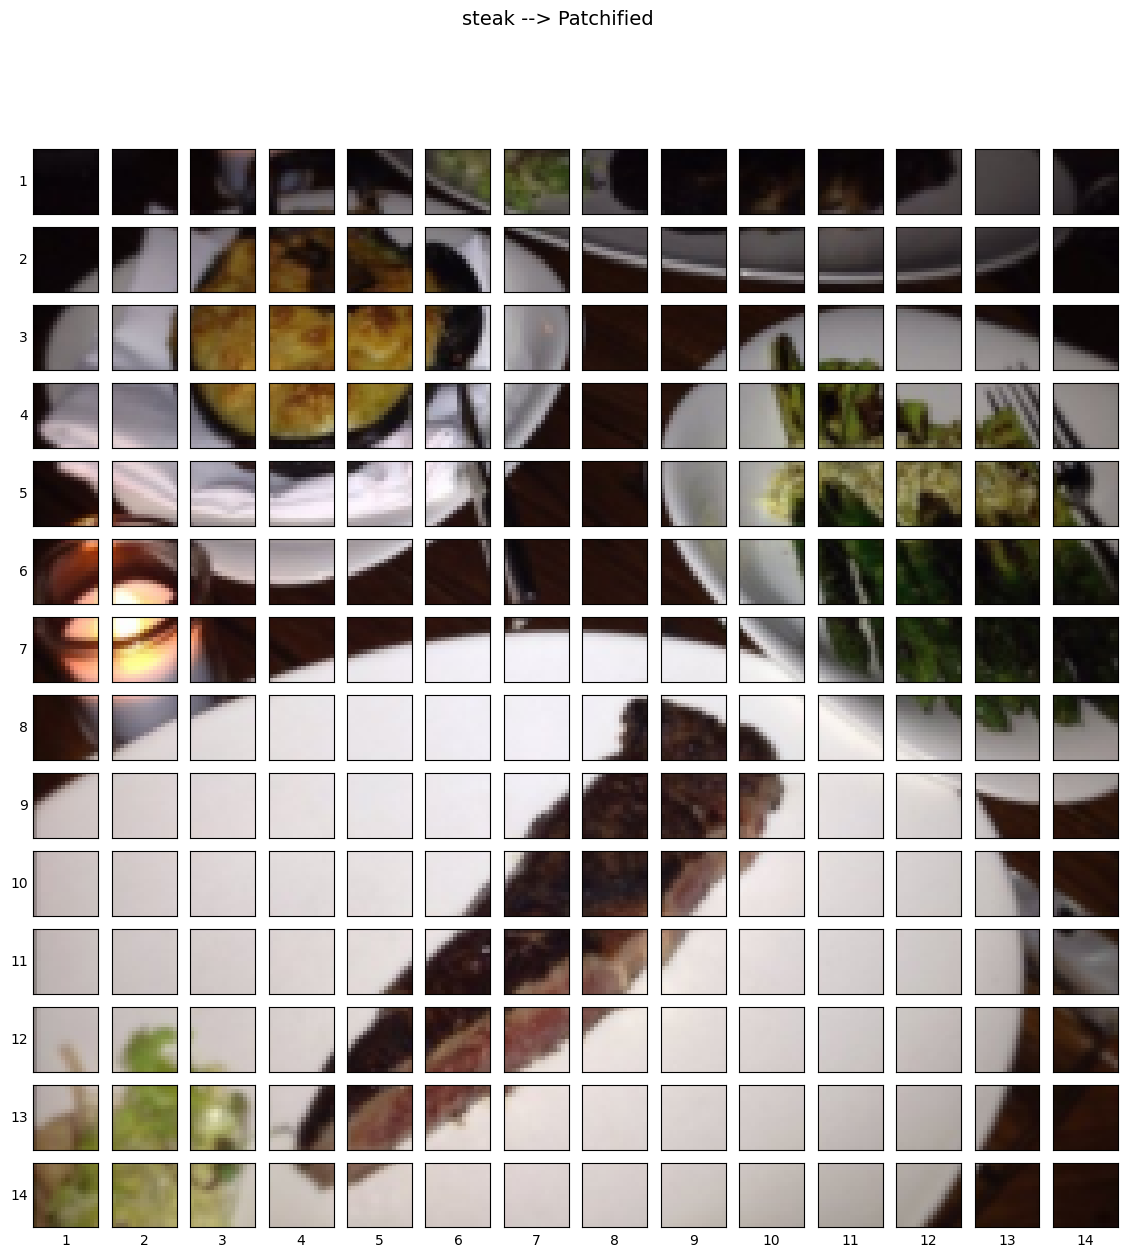

In [18]:
# Setup code to plot whole image as patches

img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f'Number of patches per row: {num_patches}\
  \nNumber of patches per column: {num_patches}\
  \nTotal patches: {num_patches * num_patches}\
  \nPatch size: {patch_size} pixels x {patch_size} pixels')

# Create a series of subplots
fig, axs = plt.subplots(
    nrows=img_size // patch_size,
    ncols=img_size // patch_size, # one column for each patch
    sharex=True,
    sharey=True,
    figsize=(num_patches, num_patches)
)

# Loop through height and width of images

for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
  for j, patch_width in  enumerate(range(0, img_size, patch_size)):

    # Plot the permted image on different axes

    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                    patch_width:patch_width+patch_size,
                                    :]); # get all color channels

    # Setup label information for each subplot

    axs[i, j].set_ylabel(
        i+1,
        rotation="horizontal",
        horizontalalignment="right",
        verticalalignment="center"
    )
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# Setup a title for the plot

fig.suptitle(f'{class_names[label]} --> Patchified', fontsize=14)

plt.show()

##### Creating image patches and turrning them into embeddings

In [19]:
# Create Conv2d layer to turn image into patches of learnable feature maps  (embeddiings)

from torch import nn

# Set the patch size
patch_size = 16

# Create Conv2d layer with hyperparameters from ViT paper

conv2d = nn.Conv2d(
    in_channels=3, # for color images
    out_channels=768, # embedding size
    kernel_size=patch_size,
    stride=patch_size,
    padding=0
)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

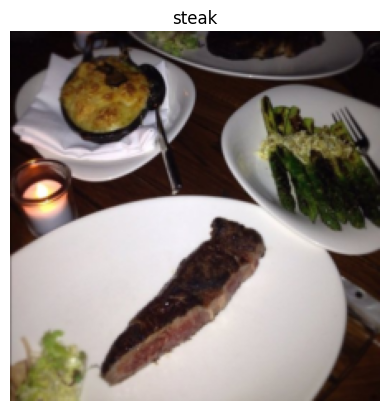

In [20]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [21]:
# Pass image through the convolutional layer

image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channels, height, width)
print(image_out_of_conv.shape) # [batch_size, embedding_dim, feature_map_heigh, feature_map_width]

torch.Size([1, 768, 14, 14])


In [22]:
image_out_of_conv.requires_grad # pytorch tracks gradients, which will be updated by gradient descent when optimizers are called

True

Showing random convolutional feature maps from indexes: [273, 506, 684, 227, 32]


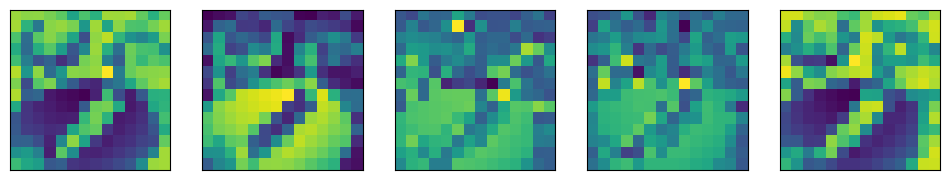

In [23]:
# Plot random convolutional feature maps (embeddings)

import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

# Plot random image feature maps

for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension, and remove from grad tracking/switch to numpy for matplotlib
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [24]:
# Get single feature map in tensor form

single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.0233,  0.0194,  0.0647,  0.0179,  0.0584, -0.0682, -0.0610,
           -0.0507,  0.0160,  0.0132,  0.0310, -0.0115, -0.0685, -0.0040],
          [ 0.0241,  0.0319, -0.2417, -0.0027,  0.0909, -0.0824, -0.0650,
           -0.0629, -0.1685, -0.1292, -0.1004, -0.1055,  0.0225,  0.0227],
          [ 0.0226, -0.1988, -0.0370, -0.0901, -0.1067, -0.0275, -0.1911,
            0.0110,  0.0070, -0.1227, -0.2281, -0.2112, -0.0981,  0.0821],
          [-0.0316, -0.1267, -0.0028, -0.0928,  0.1128, -0.1547, -0.1981,
            0.0112, -0.0285, -0.2304, -0.0607, -0.0913, -0.1207, -0.1493],
          [ 0.1576, -0.3326, -0.2835, -0.2569, -0.2981, -0.4625,  0.0166,
            0.0104, -0.0970, -0.2931, -0.0275, -0.0766, -0.1500,  0.0331],
          [ 0.0433,  0.0058, -0.1425, -0.1858, -0.1233,  0.0311,  0.0277,
            0.0157, -0.0898, -0.2092,  0.0221, -0.0244,  0.0062,  0.0133],
          [ 0.0708, -0.2404, -0.0597,  0.1193,  0.0373, -0.2827, -0.4412,
           -0.3873, -0.1628, -0.

##### Flatten the patch embedding for input criteria of ViT Encoder

In [25]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


In [26]:
from torch import nn

flatten_layer = nn.Flatten(
    start_dim=2,
    end_dim=3
)

# for single image, 768 feature maps of size 14 height and 14 weight --> for single imag, 768 feature maps of size 196

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Origina simage shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


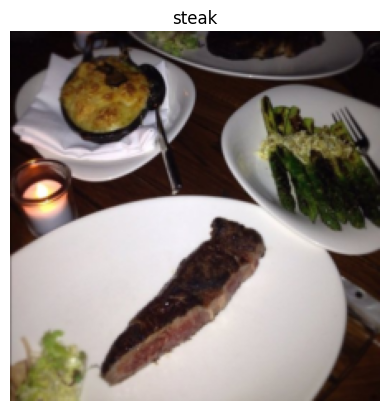

In [27]:
# Put everything together

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Origina simage shape: {image.shape}")

# Turn image into feature maps

image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension
print(f"Image feature map (patches) shape: {image_conv_feature_map.shape}")

# Flatten the feature maps

image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [28]:
# Rearrange output of flattened layer

# for single image, 768 feature maps of size 196 --> for single image, size 196 for 768 feature maps

image_out_of_conv_flattened_permutted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_permutted.shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


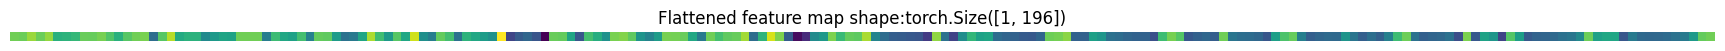

In [29]:
# Get a single flattened feature map

single_flattened_feature_map = image_out_of_conv_flattened_permutted[:, :, 0]

# Plot the flattened feature map vsually

plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape:{single_flattened_feature_map.shape}")
plt.axis(False);

#### Turning the ViT patch embedding layer into PyTorch module

In [30]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels:int=3, patch_size:int=16, embedding_dim:int=768):
     super().__init__()

     self.patch_size = patch_size

     self.patcher = nn.Conv2d(
         in_channels=in_channels,
         out_channels=embedding_dim,
         kernel_size=patch_size,
         stride=patch_size,
         padding=0
     )

     self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  def forward(self, x):
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    return x_flattened.permute(0, 2, 1)


In [31]:
set_seeds()

# Create an instance of patch embedding layer

patchify = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)

print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding squence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding squence shape: torch.Size([1, 196, 768])


In [32]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

# patchify(rand_image_tensor_bad)

#### Creating the class token embedding to prepend to patch embedding

In [33]:
patch_embedded_image

tensor([[[-5.6084e-02, -7.7377e-03, -2.2798e-02,  ...,  4.0891e-02,
          -3.3378e-02,  1.5176e-02],
         [-9.2476e-02,  1.9493e-02, -1.3609e-01,  ...,  2.1541e-02,
           9.4445e-03,  3.9007e-03],
         [-2.0718e-01,  1.3594e-01, -6.8624e-02,  ...,  1.1638e-01,
          -8.9623e-02, -1.2686e-01],
         ...,
         [-4.6684e-01, -1.4064e-04, -1.8215e-02,  ...,  3.4036e-01,
          -3.0027e-01,  2.4861e-01],
         [-6.7917e-02, -4.4843e-02, -1.8936e-02,  ...,  7.4712e-02,
          -7.1640e-02,  2.8128e-02],
         [-9.1431e-02, -1.4295e-02, -3.4475e-02,  ...,  3.6155e-02,
          -4.0302e-02,  4.0892e-02]]], grad_fn=<PermuteBackward0>)

In [34]:
# Get the batch size and embedding dimension

batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [35]:
# Create class token embedding as learnable parameter that shares the same size as the embedding dimesion (D)

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension, requires_grad=True))
class_token.shape

torch.Size([1, 1, 768])

In [36]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [37]:
# Add the class token embedding to the front of the patch embedding

patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1) # dim=1 is the number_of_patches dimension
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim)")

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-5.6084e-02, -7.7377e-03, -2.2798e-02,  ...,  4.0891e-02,
          -3.3378e-02,  1.5176e-02],
         [-9.2476e-02,  1.9493e-02, -1.3609e-01,  ...,  2.1541e-02,
           9.4445e-03,  3.9007e-03],
         ...,
         [-4.6684e-01, -1.4064e-04, -1.8215e-02,  ...,  3.4036e-01,
          -3.0027e-01,  2.4861e-01],
         [-6.7917e-02, -4.4843e-02, -1.8936e-02,  ...,  7.4712e-02,
          -7.1640e-02,  2.8128e-02],
         [-9.1431e-02, -1.4295e-02, -3.4475e-02,  ...,  3.6155e-02,
          -4.0302e-02,  4.0892e-02]]], grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dim)


#### Creating the Position Embedding and add to the sequence of patch embeddings

In [38]:
# Calculate N (number_of_patches)

number_of_patches = int((height * width) / patch_size ** 2)

# Get the embedding dimension

embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding

position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension))
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [39]:
# View the sequence of patch embeddings with the preprended class embedding

patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
            1.0000e+00,  1.0000e+00],
          [-5.6084e-02, -7.7377e-03, -2.2798e-02,  ...,  4.0891e-02,
           -3.3378e-02,  1.5176e-02],
          [-9.2476e-02,  1.9493e-02, -1.3609e-01,  ...,  2.1541e-02,
            9.4445e-03,  3.9007e-03],
          ...,
          [-4.6684e-01, -1.4064e-04, -1.8215e-02,  ...,  3.4036e-01,
           -3.0027e-01,  2.4861e-01],
          [-6.7917e-02, -4.4843e-02, -1.8936e-02,  ...,  7.4712e-02,
           -7.1640e-02,  2.8128e-02],
          [-9.1431e-02, -1.4295e-02, -3.4475e-02,  ...,  3.6155e-02,
           -4.0302e-02,  4.0892e-02]]], grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [40]:
# Add the postion embedding to the patch and class token embedding

patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9439, 0.9923, 0.9772,  ..., 1.0409, 0.9666, 1.0152],
         [0.9075, 1.0195, 0.8639,  ..., 1.0215, 1.0094, 1.0039],
         ...,
         [0.5332, 0.9999, 0.9818,  ..., 1.3404, 0.6997, 1.2486],
         [0.9321, 0.9552, 0.9811,  ..., 1.0747, 0.9284, 1.0281],
         [0.9086, 0.9857, 0.9655,  ..., 1.0362, 0.9597, 1.0409]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


#### Putting Equation 1 all together

In [41]:
set_seeds()

patch_size = 16

print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(
    in_channels=3,
    patch_size=patch_size,
    embedding_dim=768
)

patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dim = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding wth class token shape: {patch_embedding_class_token.shape}")

number_of_patches = int((height * width) / patch_size ** 2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding wth class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [42]:
image.shape

torch.Size([3, 224, 224])

### Equation 2: Multihead Sef-Attention. (MSA block)

In [43]:
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(
      self,
      embedding_dim:int=768,
      num_heads:int=12,
      attn_dropout:int=0
  ):
     super().__init__()

     # Create norm layer (LN)

     self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

     # Create multihead attention (MSA) layer

     self.multihead_attn = nn.MultiheadAttention(
         embed_dim=embedding_dim,
         num_heads=num_heads,
         dropout=attn_dropout,
         batch_first=True # is batch first? (batch_size, seq, feature) -> (batch_size, number_of_patches, embedding_dim)
     )

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(
        query=x,
        key=x,
        value=x,
        need_weights=False
    )

    return attn_output

In [44]:
# Create an instance of MSA Block

multihead_self_attention_block = MultiHeadSelfAttentionBlock(
  embedding_dim=768,
  num_heads=12,
  attn_dropout=0
)

# Pass the patch nad position embedding sequence through MSA block

patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA bloc: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA bloc: torch.Size([1, 197, 768])


### Equation 3: Multilayer Perceptron (MLP block)

In [45]:
class MLPBlock(nn.Module):
  def __init__(self, embedding_dim:int=768, mlp_size:int=3072, dropout:int=0.1):
     super().__init__()

     # Create the norm layer (LN)

     self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

     # Create the MLP

     self.mlp = nn.Sequential(
         nn.Linear(in_features=embedding_dim, out_features=mlp_size),
         nn.GELU(),
         nn.Dropout(p=dropout),
         nn.Linear(in_features=mlp_size, out_features=embedding_dim),
         nn.Dropout(p=dropout)
     )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)

    return x
    # return self.mlp(self.layer_norm(x)) # same as above

In [46]:
# Create an instance of MLPBlock

mlp_block = MLPBlock(embedding_dim=768, mlp_size=3072, dropout=0.1)

# Pass the output through the MLPBlock

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


In [47]:
patched_image_through_msa_block

tensor([[[-0.1816, -0.1839,  0.0889,  ..., -0.4293,  0.8455, -0.4842],
         [-0.1870, -0.1886,  0.0934,  ..., -0.4211,  0.8633, -0.5014],
         [-0.1721, -0.1801,  0.1130,  ..., -0.4166,  0.8491, -0.4983],
         ...,
         [-0.1774, -0.1704,  0.0975,  ..., -0.4377,  0.8718, -0.5151],
         [-0.1860, -0.1856,  0.0922,  ..., -0.4280,  0.8710, -0.5119],
         [-0.1802, -0.1878,  0.0921,  ..., -0.4157,  0.8668, -0.5076]]],
       grad_fn=<TransposeBackward0>)

In [48]:
patched_image_through_mlp_block

tensor([[[-0.0587, -0.0019,  0.1149,  ...,  0.0000, -0.1480,  0.1911],
         [-0.1018, -0.1147,  0.2402,  ..., -0.0816, -0.1300,  0.2177],
         [-0.0258, -0.0489,  0.2654,  ..., -0.0000, -0.1971,  0.1889],
         ...,
         [-0.2004, -0.0007,  0.2372,  ...,  0.1313, -0.2026,  0.2877],
         [-0.1332,  0.0499,  0.0000,  ...,  0.0728, -0.1811,  0.0769],
         [-0.0693, -0.0264,  0.1936,  ..., -0.0926, -0.1642,  0.1844]]],
       grad_fn=<MulBackward0>)

#### Creating the Transformer Encoder

In [49]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self, embedding_dim:int=768, num_heads:int=12, mlp_size:int=3072, mlp_dropout:int=0.1, attn_droput:int=0):
     super().__init__()

     # Create MSA block (Equation 2)

     self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_droput)

     # Create MLP block (Equation 3)

     self.mlp_block = MLPBlock(embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x # residual/skip connection for equation 2
    x = self.mlp_block(x) + x # residual/skip connection for equation 3

    return x

In [50]:
# Create an instance of TransformerEncoderBlock()

transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary

summary(
    model=transformer_encoder_block,
    input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

#### Create a custom Transformer Encoder layer with in-built PyTorch Layer

In [51]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768,
    nhead=12,
    dim_feedforward=3072,
    dropout=0.1,
    activation="gelu",
    batch_first=True,
    norm_first=True
)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [52]:
# Get a summary using torchinfo.summary

summary(
    model=torch_transformer_encoder_layer,
    input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

### Putting it all together to create ViT

In [53]:
# Create a ViT class

class ViT(nn.Module):
  def __init__(
      self,
      img_size:int=224,
      in_channels:int=3,
      patch_size:int=16,
      num_transformer_layers:int=12,
      embedding_dim:int=768,
      mlp_size:int=3072,
      num_heads:int=12,
      attn_dropout:int=0,
      mlp_dropout:int=0.1,
      embedding_dropout:int=0.1, # dropout for patch and position embeddings
      num_classes:int=1000
  ):

    super().__init__()

    # Make an assertion that image size is compatible with patch size

    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}"

    # Calculate the number of patches (height * width / patch ^ 2)

    self.num_patches = (img_size * img_size) // patch_size ** 2

    # Create learnable class embedding (needs to go at front of sequence of patch embeddings)

    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)

    # Create learnable position embedding

    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

    # Create embedding dropout value

    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim)

    # Create the Transformer Encoder block

    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(
        embedding_dim=embedding_dim,
        num_heads=num_heads,
        mlp_size=mlp_size,
        mlp_dropout=mlp_dropout
    ) for _ in range (num_transformer_layers)])

    # Create classifier head

    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim, out_features=num_classes)
    )

  def forward(self, x):
    # Get the batch size

    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size (equation 1) which means for creating embeddings for each image in a batch

    class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimensions

    # Create the patch embedding (equation 1)

    x = self.patch_embedding(x)

    # Concat class token embedding and patch embedding (equation 1)

    x = torch.cat((class_token, x), dim=1) # (batch_size, number_of_patches + 1, embedding_dim)

    # Add position embedding to class token and patch embedding

    x = self.position_embedding + x

    # Apply droput to patch embeddings directly after adding positional to patch embeddings

    x = self.embedding_dropout(x)

    # Pass position and patch embedding to Transformer Encoder (equation 2 & 3)

    x =self.transformer_encoder(x)

    # Put 0th index logit through classifier (equation 4)

    x = self.classifier(x[:, 0])


    return x

In [54]:
batch_size=32
embedding_dim=768
class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)

class_embedding_expanded = class_embedding.expand(batch_size, -1, -1)

print(class_embedding.shape)
print(class_embedding_expanded.shape)

torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [55]:
# vit = ViT()
# vit

In [56]:
set_seeds()

# Create a random image tensor with same shape as a single image

random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we are working with (pizza, steak, sushi)

vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance

vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

### Visual summary of ViT model

In [57]:
summary(
    model=ViT(num_classes=len(class_names)),
    input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## Setting up training code for ViT

### Creating an optimizer

In [58]:
optimizer = torch.optim.Adam(vit.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=0.1)

### Creating a Loss Function

In [59]:
loss_fn = torch.nn.CrossEntropyLoss()

## Training ViT model

In [60]:
set_seeds()

results = engine.train(model=vit, train_dataloader=train_dataloader, test_dataloader=test_dataloader, epochs=10, optimizer=optimizer, loss_fn=loss_fn, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.8769 | train_acc: 0.3008 | test_loss: 1.0393 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.5149 | train_acc: 0.3047 | test_loss: 1.5085 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.4133 | train_acc: 0.2617 | test_loss: 1.4602 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.2590 | train_acc: 0.4102 | test_loss: 1.9581 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3003 | train_acc: 0.2812 | test_loss: 1.6453 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2523 | train_acc: 0.2969 | test_loss: 1.7504 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1795 | train_acc: 0.4102 | test_loss: 3.2498 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.4590 | train_acc: 0.2852 | test_loss: 1.3791 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.3394 | train_acc: 0.3672 | test_loss: 1.2890 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.4096 | train_acc: 0.3164 | test_loss: 1.3272 | test_acc: 0.2604


#### Plotting Loss Curves

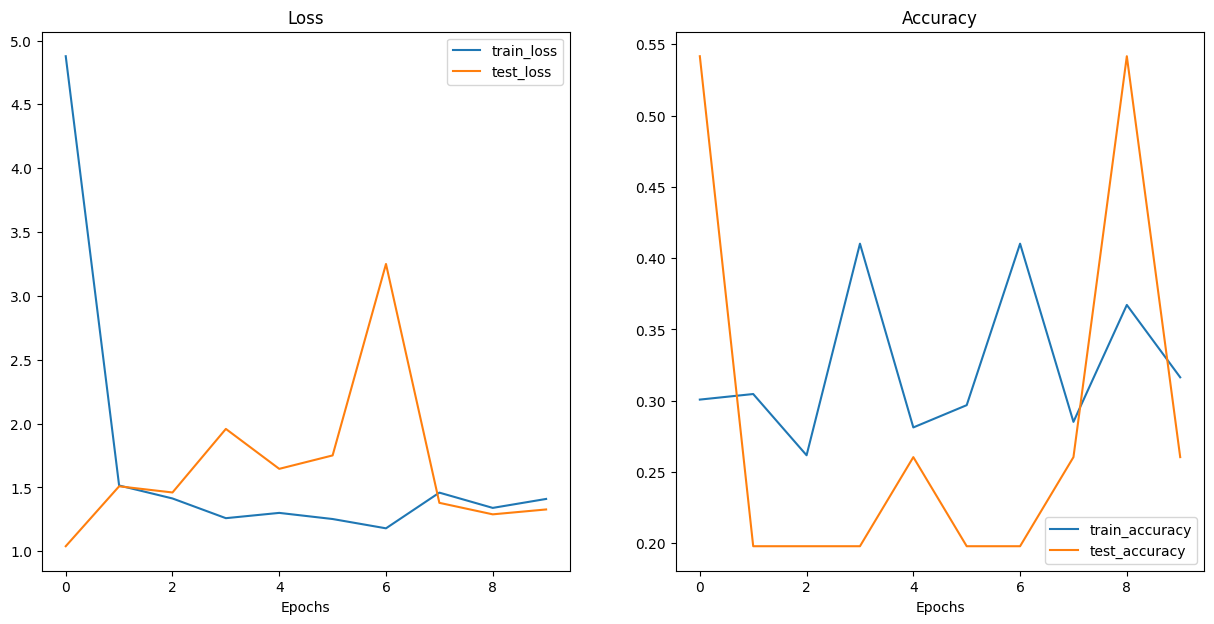

In [61]:
plot_loss_curves(results)

## Using Pretrained ViT (prevent overfitting and have limited datasets based on PyTorch)

In [66]:
# Get pretrained weight for ViT-Base

pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" = best available

# Setup a ViT model instance with pretrained weights

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters

for parameter in pretrained_vit.parameters():
  parameter.requires_grad=False

# Update the classifer head

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [67]:
summary(
    model=pretrained_vit,
    input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

## Preparing data for pretrained ViT model

In [68]:
# Get automatic transforms from pretrained ViT weights

vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [69]:
# Setup dataloaders

train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)

## Train feature extractor ViT model

In [70]:
# Create optimizer and loss function

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT

set_seeds()
pretrained_vit_results = engine.train(
    model=pretrained_vit,
    train_dataloader=train_dataloader_pretrained,
    test_dataloader=test_dataloader_pretrained,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
  )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


## Plot Loss Curves of pretrained ViT feature extractor model

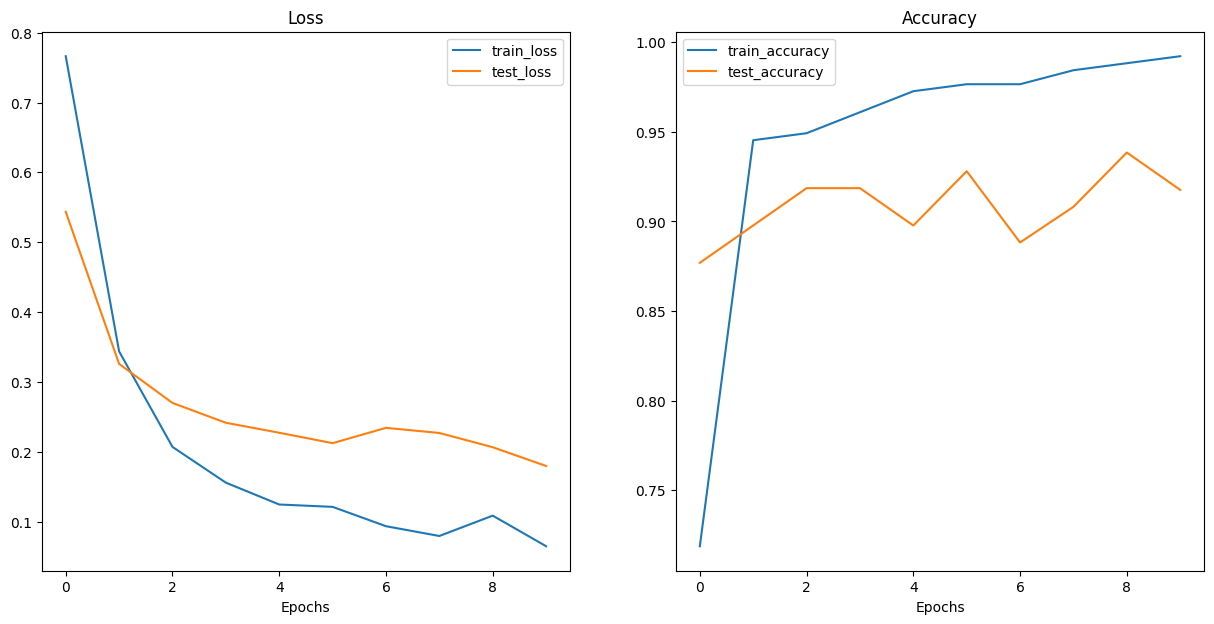

In [71]:
plot_loss_curves(pretrained_vit_results)

## Save best performing ViT model

In [73]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(
    model=pretrained_vit,
    target_dir="models",
    model_name="pretrained_pizza_steak_sushi.pth"
)

[INFO] Saving model to: models/pretrained_pizza_steak_sushi.pth


In [74]:
from pathlib import Path

# Get the model size in bytes thends convert to megabytes

pretrained_vit_model_size = Path("models/pretrained_pizza_steak_sushi.pth").stat().st_size // (1024 * 1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


## Predicting on a custom image

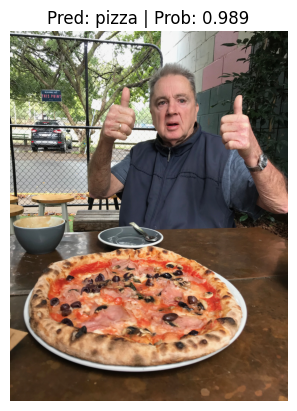

In [75]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)